In [1]:
#https://docs.rapids.ai/install/#selector # conda activate rapids-25.04

In [ ]:
# !pip install polars[gpu]

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
import tqdm
from ydata_profiling import ProfileReport
from cuml.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest , f_classif
from cuml.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import seaborn as sns
import cuml
from tqdm import  tqdm
cuml.set_global_output_type('numpy')
import os


In [2]:
df = pl.read_csv("data_2/csai-253-project-phase-2/train.csv")
df_test = pl.read_csv("data_2/csai-253-project-phase-2/test.csv")
df.shape , df_test.shape

((938583, 22), (104287, 22))

In [55]:
"""
Id: Unique identifier for each row in the test set.
flow_time: Duration of network flow.
header_size: Size of the packet headers.
packet_duration: Duration of individual packets.
overall_rate: Overall data transfer rate.
src_rate: Data transfer rate from the source.
dst_rate: Data transfer rate towards the destination.
fin_packets: Number of packets flagged as finished (FIN).
urg_packets: Number of urgent packets (URG).
rst_packets: Number of reset packets (RST).
max_value: Maximum value observed in packet data.
syn_flags: Number of SYN (synchronize) flags detected.
rst_flags: Number of RST (reset) flags detected.
psh_flags: Number of PSH (push) flags detected.
ack_flags: Number of ACK (acknowledge) flags detected.
protocol_http: Indicates HTTP protocol usage.
protocol_https: Indicates HTTPS protocol usage.
protocol_tcp: Indicates TCP protocol usage.
protocol_udp: Indicates UDP protocol usage.
protocol_icmp: Indicates ICMP protocol usage.
label (only in train.csv): Type of cyber-attack to be predicted (e.g., DDoS, DoS, benign).
"""
df.schema

Schema([('flow_time', Float64),
        ('header_size', Float64),
        ('packet_duration', Float64),
        ('overall_rate', Float64),
        ('src_rate', Float64),
        ('dst_rate', Float64),
        ('fin_packets', Float64),
        ('urg_packets', Float64),
        ('rst_packets', Float64),
        ('max_value', Float64),
        ('value_covariance', Float64),
        ('fin_flags', Int64),
        ('syn_flags', Int64),
        ('rst_flags', Int64),
        ('psh_flags', Int64),
        ('ack_flags', Int64),
        ('protocol_http', Int64),
        ('protocol_https', Int64),
        ('protocol_tcp', Int64),
        ('protocol_udp', Int64),
        ('protocol_icmp', Int64),
        ('label', String)])

In [56]:
df.describe()

shape: (9, 23)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ flow_time ┆ header_si ┆ packet_du ┆ … ┆ protocol_ ┆ protocol_ ┆ protocol_ ┆ label    │
│ ---       ┆ ---       ┆ ze        ┆ ration    ┆   ┆ tcp       ┆ udp       ┆ icmp      ┆ ---      │
│ str       ┆ f64       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ str      │
│           ┆           ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 938583.0  ┆ 938583.0  ┆ 938583.0  ┆ … ┆ 938583.0  ┆ 938583.0  ┆ 938583.0  ┆ 938583   │
│ null_coun ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0        │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ mean      ┆ 13.42515  ┆ 101813.42 ┆ 82.664589 ┆ … ┆ 0.574175  ┆ 0.21141   ┆ 0.164314  ┆ null     │
│           ┆           ┆ 3375      ┆           ┆   ┆           ┆           ┆           ┆          │
│ std       ┆ 5898.0987 ┆ 1.8014e6  ┆ 166.98632 ┆ … ┆ 0.494468  ┆ 0.408309  ┆ 0.37056   ┆ null     │
│           ┆ 33        ┆           ┆ 5         ┆   ┆           ┆           ┆           ┆          │
│ min       ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ BenignTr │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ affic    │
│ 25%       ┆ 0.0       ┆ 54.0      ┆ 64.0      ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ null     │
│ 50%       ┆ 0.0       ┆ 54.0      ┆ 64.0      ┆ … ┆ 1.0       ┆ 0.0       ┆ 0.0       ┆ null     │
│ 75%       ┆ 0.101755  ┆ 364.0     ┆ 64.0      ┆ … ┆ 1.0       ┆ 0.0       ┆ 0.0       ┆ null     │
│ max       ┆ 4.9301e6  ┆ 3.3111737 ┆ 6525.74   ┆ … ┆ 1.0       ┆ 1.0       ┆ 1.0       ┆ Recon    │
│           ┆           ┆ e8        ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [3]:
#how may classes do we have?
print(df["label"].unique().value_counts().sum()["count"][0] ," unique labels")
# df = df.with_columns(pl.col("label").str.to_lowercase()) # case folding , expression object: pl.col("label")
#Are the classes un-balanced
quickOVERVIEW = df["label"].value_counts().with_columns((pl.col("count")/df["label"].shape[0] *100).alias("percentage"))
quickOVERVIEW

6  unique labels


shape: (6, 3)
┌───────────────┬────────┬────────────┐
│ label         ┆ count  ┆ percentage │
│ ---           ┆ ---    ┆ ---        │
│ str           ┆ u32    ┆ f64        │
╞═══════════════╪════════╪════════════╡
│ dos           ┆ 163428 ┆ 17.412205  │
│ benigntraffic ┆ 21987  ┆ 2.342574   │
│ ddos          ┆ 687027 ┆ 73.198321  │
│ recon         ┆ 6433   ┆ 0.685395   │
│ mirai         ┆ 53395  ┆ 5.688895   │
│ mitm          ┆ 6313   ┆ 0.67261    │
└───────────────┴────────┴────────────┘

<BarContainer object of 6 artists>

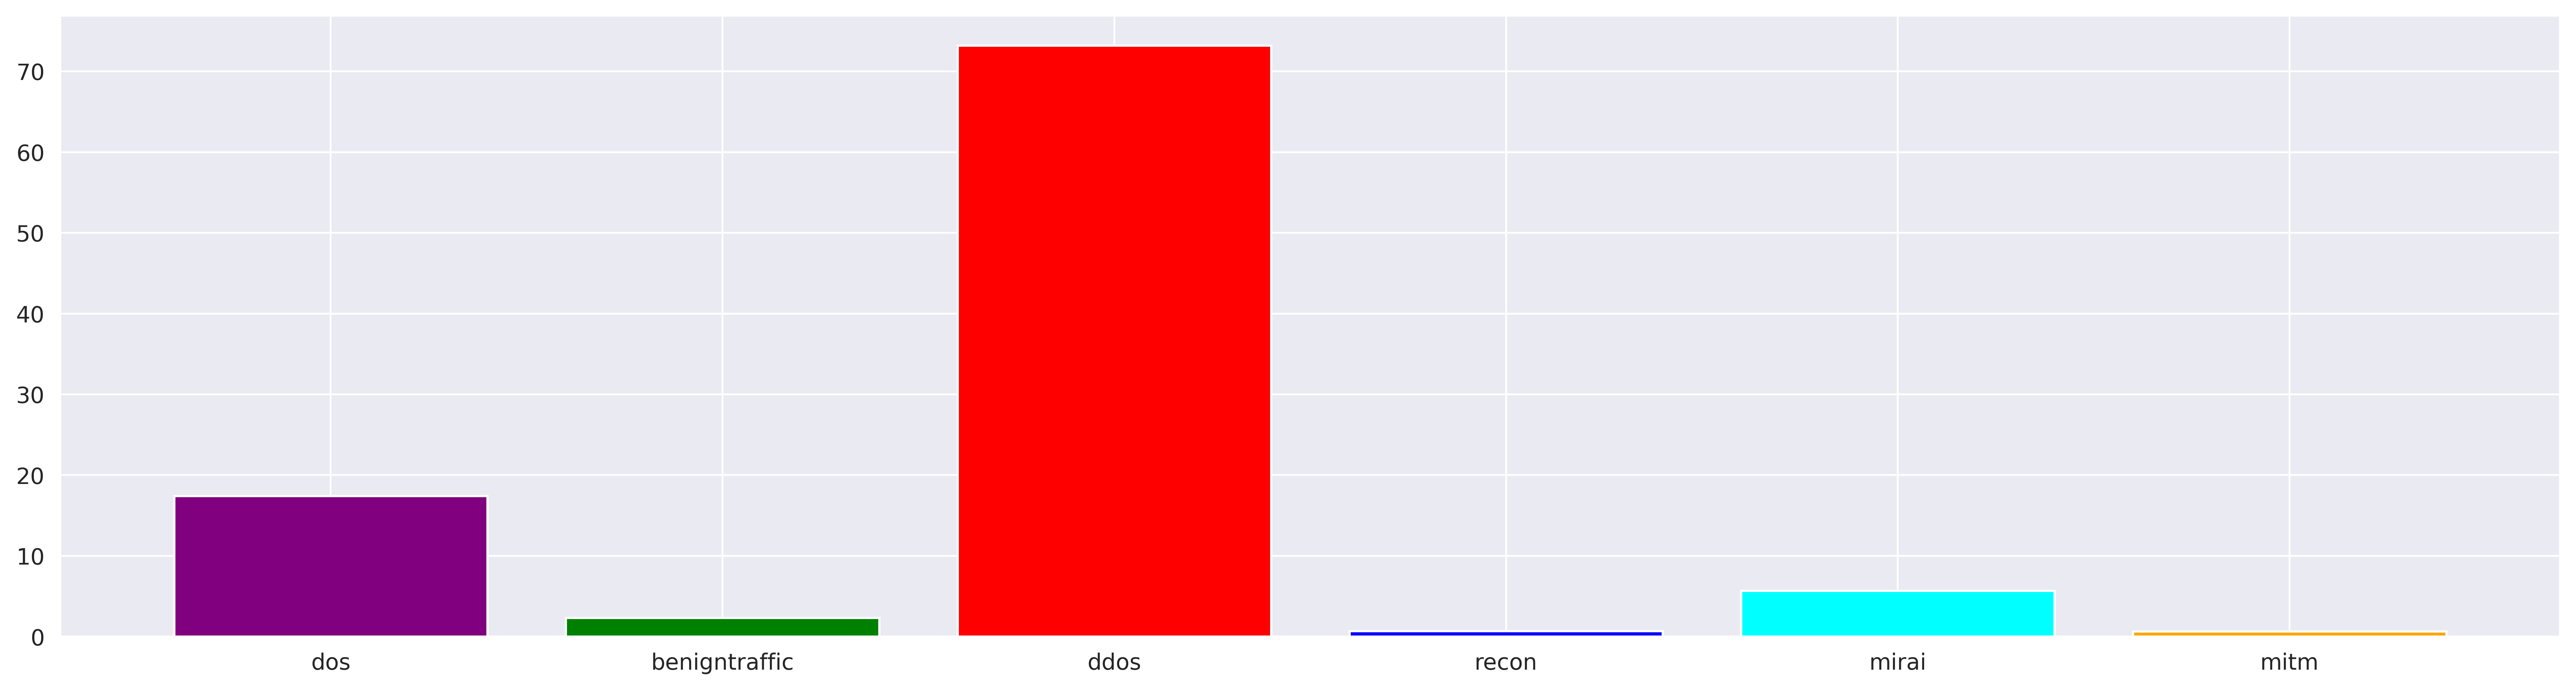

In [4]:
plt.figure(figsize=(20, 5), dpi=500)
plt.bar(
    quickOVERVIEW["label"], 
    height=quickOVERVIEW["percentage"] , 
    color= quickOVERVIEW["label"].replace({
    "ddos": "red",             
    "recon": "blue",           
    "benigntraffic": "green", 
    "mitm": "orange",          
    "dos": "purple",          
    "mirai": "cyan"           
}
))

In [5]:
profile = ProfileReport(df.to_pandas(), title="Profiling Report" , explorative=True , lazy= True , minimal = True)
# Display the report (Kaggle should automatically render it)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 29.15it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# ScaledFeatures =  StandardScaler().fit_transform(df.select(cs.numeric()).to_numpy())
# df = pl.concat(items = [pl.DataFrame(ScaledFeatures , schema = df.select(cs.numeric()).columns) , df.select("label")] ,  how="horizontal")


In [3]:
#https://medium.com/@aakash013/outlier-detection-treatment-z-score-iqr-and-robust-methods-398c99450ff3
from scipy import stats
outliers = stats.median_abs_deviation(x=df.select(cs.numeric()),) #https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.median_abs_deviation.html
outliers.shape
names = df.select(cs.numeric()).columns
for i , outlier in enumerate(outliers):
    if(outlier>0):
        print(names[i]  , outlier)
"""

header_size: Size of the packet headers.
overall_rate: Overall data transfer rate.
src_rate: Data transfer rate from the source.
max_value: Maximum value observed in packet data.

"""

header_size 54.0
overall_rate 14.903951537000001
src_rate 14.903951537000001
max_value 2.520000000000003


'\n\nheader_size: Size of the packet headers.\noverall_rate: Overall data transfer rate.\nsrc_rate: Data transfer rate from the source.\nmax_value: Maximum value observed in packet data.\n\n'

In [13]:
def skimmer(df: pl.DataFrame) -> dict:
    out = {}
    for col in df.columns:
        if df[col].dtype == pl.Utf8:
            out[f"{col}"] = {"col_unique_values": df[col].unique().to_list(), "data_type": df[col].dtype}
        else:
            out[f"{col}"] = {"col_values_range": [df[col].min(), df[col].max()], "data_type": df[col].dtype}
    return out
print(skimmer(df))

{'flow_time': {'col_values_range': [0.0, 4930147.302], 'data_type': Float64}, 'header_size': {'col_values_range': [0.0, 331117370.0], 'data_type': Float64}, 'packet_duration': {'col_values_range': [0.0, 6525.74], 'data_type': Float64}, 'overall_rate': {'col_values_range': [0.0, 7340032.0], 'data_type': Float64}, 'src_rate': {'col_values_range': [0.0, 7340032.0], 'data_type': Float64}, 'dst_rate': {'col_values_range': [0.0, 0.848465429], 'data_type': Float64}, 'fin_packets': {'col_values_range': [0.0, 19.5], 'data_type': Float64}, 'urg_packets': {'col_values_range': [0.0, 4136.7], 'data_type': Float64}, 'rst_packets': {'col_values_range': [0.0, 9331.5], 'data_type': Float64}, 'max_value': {'col_values_range': [42.0, 30329.2], 'data_type': Float64}, 'value_covariance': {'col_values_range': [0.0, 137284386.3], 'data_type': Float64}, 'fin_flags': {'col_values_range': [0, 1], 'data_type': Int64}, 'syn_flags': {'col_values_range': [0, 1], 'data_type': Int64}, 'rst_flags': {'col_values_range'

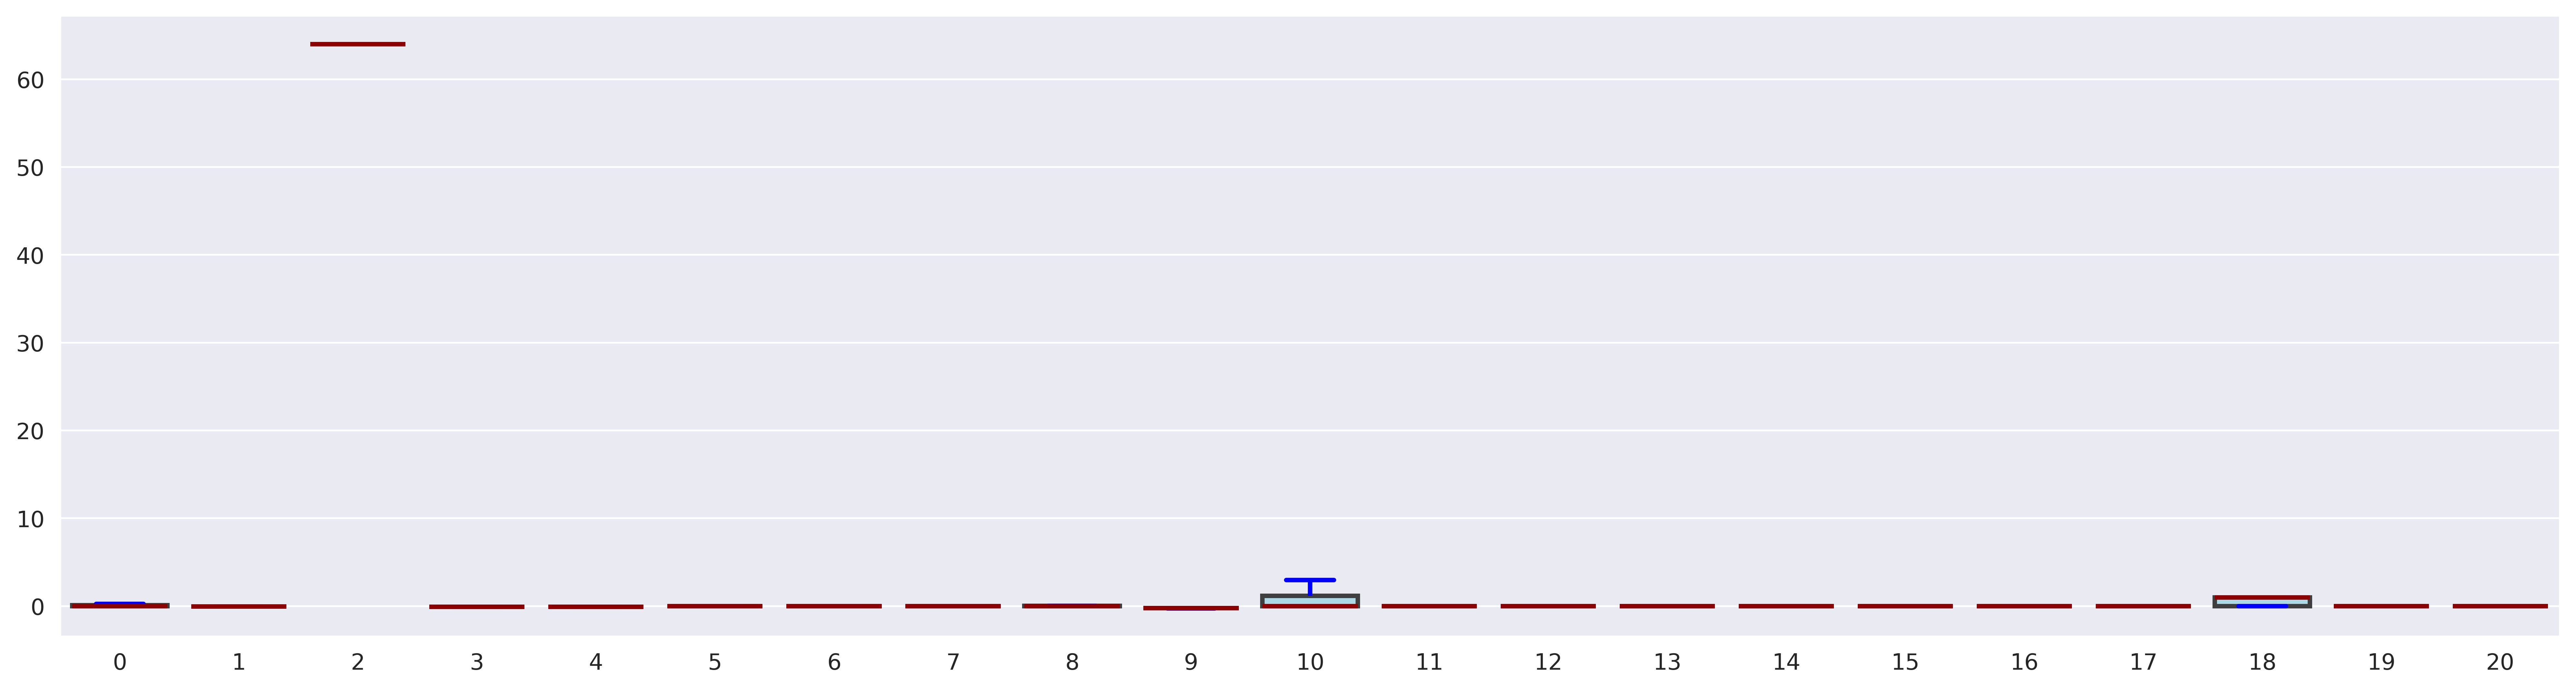

In [7]:
plt.figure(figsize=(20, 5), dpi=500)

sns.boxplot(
    data= df.select((cs.numeric())),#numeric columns only
    showfliers=False,  # hide extreme outliers
    boxprops=dict(facecolor="lightblue", linewidth=2),  # box styling
    whiskerprops=dict(color="blue", linewidth=2, linestyle="-"),
    medianprops=dict(color="darkred", linewidth=2),
    capprops=dict(color="blue", linewidth=2),
    # gap=1.5
)

plt.show()

In [14]:
df.columns[1] , df.columns[3] , df.columns[4] ,df.columns[9]

('header_size', 'overall_rate', 'src_rate', 'max_value')

In [3]:
# Option 1: Replace only these columns with scaled versions
highly_dispersed = ['header_size', 'overall_rate', 'src_rate', 'max_value']
scaled_data = StandardScaler().fit_transform(df.select(highly_dispersed).to_numpy())
scaled_df = pl.DataFrame(scaled_data, schema=highly_dispersed)

# Replace original columns with scaled versions
for i, col in enumerate(highly_dispersed):
    df = df.with_columns(pl.lit(scaled_df[:, i]).alias(col))

# Option 2: Or use robust scaling instead for these specific columns
# from sklearn.preprocessing import RobustScaler
# robust_scaled = RobustScaler().fit_transform(df.select(highly_dispersed).to_numpy())
# robust_df = pl.DataFrame(robust_scaled, schema=highly_dispersed)
# 
# for i, col in enumerate(highly_dispersed):
#     df = df.with_columns(pl.lit(robust_df[:, i]).alias(col))
    
df[highly_dispersed]

shape: (938_583, 4)
┌─────────────┬──────────────┬───────────┬───────────┐
│ header_size ┆ overall_rate ┆ src_rate  ┆ max_value │
│ ---         ┆ ---          ┆ ---       ┆ ---       │
│ f64         ┆ f64          ┆ f64       ┆ f64       │
╞═════════════╪══════════════╪═══════════╪═══════════╡
│ -0.047916   ┆ -0.013552    ┆ -0.013552 ┆ -0.246712 │
│ -0.054464   ┆ -0.024301    ┆ -0.024301 ┆ -0.238408 │
│ -0.056419   ┆ -0.091085    ┆ -0.091085 ┆ 0.009388  │
│ -0.037075   ┆ -0.02376     ┆ -0.02376  ┆ -0.217396 │
│ -0.05643    ┆ -0.091447    ┆ -0.091447 ┆ -0.029415 │
│ …           ┆ …            ┆ …         ┆ …         │
│ -0.056489   ┆ -0.091043    ┆ -0.091043 ┆ -0.186975 │
│ -0.056419   ┆ -0.090959    ┆ -0.090959 ┆ 0.009388  │
│ -0.038113   ┆ 0.710368     ┆ 0.710368  ┆ -0.246246 │
│ -0.040307   ┆ -0.029497    ┆ -0.029497 ┆ -0.245354 │
│ -0.05604    ┆ -0.091312    ┆ -0.091312 ┆ -0.23119  │
└─────────────┴──────────────┴───────────┴───────────┘

In [6]:
selector = SelectKBest(score_func=f_classif, k=19)

selector.fit(df.select(cs.numeric()), df["label"])

selected_indices = selector.get_support(indices=True)
print(selected_indices , len(selected_indices),"features")
selected_features = [df.select(cs.numeric()).columns[i] for i in selected_indices]
print("\nSelected features: \n", selected_features)

[ 1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 19 features

Selected features: 
 ['header_size', 'packet_duration', 'overall_rate', 'src_rate', 'fin_packets', 'urg_packets', 'rst_packets', 'max_value', 'value_covariance', 'fin_flags', 'syn_flags', 'rst_flags', 'psh_flags', 'ack_flags', 'protocol_http', 'protocol_https', 'protocol_tcp', 'protocol_udp', 'protocol_icmp']


In [13]:
# not as we did in phase 1 , we will be testing undersampling and oversampling, 
# validated my idea by generative pre-trained transformers

"""You're dealing with a pretty classic **class imbalance problem**, especially with `"ddos"` being massively overrepresented and `"benigntraffic"`, `"mitm"`, and `"recon"` heavily underrepresented.

Here's a breakdown of your idea, and some suggestions:

---

### ✅ Your Plan (Under + Over Sampling):
Using **undersampling on the majority ("ddos")** and then **oversampling the minority classes** is totally reasonable and commonly done. Here's how it might work:

#### Step-by-step version of your plan:
1. **Undersample "ddos"** to reduce its impact.
2. **Oversample "benigntraffic", "mitm", "recon"**, and maybe even "mirai" to get a more balanced dataset.
3. **Possibly leave "dos" as is**, or slightly adjust it.

---

### 🧠 Tips on Executing It:

#### 1. ⚖️ **Target Balance Strategy**
Decide your final desired sample size per class. Example ideas:
- Match to the size of "mirai" (~50K)
- Or go a bit lower to reduce training size, say ~30K per class
- Avoid exact balance — slight randomness can help generalization

#### 2. 🧹 **Undersampling "ddos"**
You can randomly select ~30K–50K rows from "ddos" (from 687K). Make sure to **shuffle** before picking.

#### 3. 🔁 **Oversampling Minorities**
Use techniques like:
- **Random Oversampling** (e.g., simple duplication)
- **SMOTE/ADASYN** (synthetic data generation, if the features support it — i.e., numeric and continuous)

> Note: SMOTE doesn’t work well with categorical data unless encoded carefully.

#### 4. 🧪 **Be Careful with Oversampling**
If you're evaluating on the same dataset, make sure not to **leak duplicated synthetic samples into your validation set** — only oversample in the training split.

---

### ⚖️ Alternative: Use Class Weights
If you're using tree-based models (like XGBoost, LightGBM) or neural nets, consider using **class weighting** instead. It avoids changing the actual data and simply adjusts the cost of misclassification.

---

### 👀 Example Target Distribution
| Label          | Target Count |
|----------------|--------------|
| ddos           | 30,000       |
| benigntraffic  | 30,000       |
| mitm           | 30,000       |
| mirai          | 30,000       |
| recon          | 30,000       |
| dos            | 30,000       |

You could tune this depending on whether you want full balance or slight realism.

---

### 📦 TL;DR
- Your under+over strategy is solid.
- Make sure not to leak synthetic samples into validation/test.
- Consider class weights as a simpler alternative if supported.
- Don’t overdo oversampling — can lead to overfitting if minority class is too tiny.

Would you like help with writing some code to implement this in Python (e.g., using `pandas`, `sklearn`, `imbalanced-learn`)?"""

'You\'re dealing with a pretty classic **class imbalance problem**, especially with `"ddos"` being massively overrepresented and `"benigntraffic"`, `"mitm"`, and `"recon"` heavily underrepresented.\n\nHere\'s a breakdown of your idea, and some suggestions:\n\n---\n\n### ✅ Your Plan (Under + Over Sampling):\nUsing **undersampling on the majority ("ddos")** and then **oversampling the minority classes** is totally reasonable and commonly done. Here\'s how it might work:\n\n#### Step-by-step version of your plan:\n1. **Undersample "ddos"** to reduce its impact.\n2. **Oversample "benigntraffic", "mitm", "recon"**, and maybe even "mirai" to get a more balanced dataset.\n3. **Possibly leave "dos" as is**, or slightly adjust it.\n\n---\n\n### 🧠 Tips on Executing It:\n\n#### 1. ⚖️ **Target Balance Strategy**\nDecide your final desired sample size per class. Example ideas:\n- Match to the size of "mirai" (~50K)\n- Or go a bit lower to reduce training size, say ~30K per class\n- Avoid exact bala

In [32]:
#https://medium.com/anolytics/all-you-need-to-know-about-encoding-techniques-b3a0af68338b
# import category_encoders as ce
# cbe_encoder = ce.cat_boost.CatBoostEncoder()
# p_df = df.to_pandas()
# train_cbe = cbe_encoder.fit_transform(p_df[selected_features], p_df['label']) #approach1 --------> not applicable


In [4]:

from cuml.preprocessing import LabelEncoder
le = LabelEncoder()
y_numeric = le.fit_transform(df['label'])  # now 0,1,2


In [5]:
map_ = {}
map_.update({i: val for i, val in enumerate(le.classes_.to_pandas().to_list())})
map_

{0: 'BenignTraffic', 1: 'DDoS', 2: 'DoS', 3: 'MITM', 4: 'Mirai', 5: 'Recon'}



The issue is with the list comprehension syntax trying to assign values to a dictionary. Python does not allow direct assignment within list comprehension. The code should use dictionary comprehension or the update() method instead.


In [6]:
import warnings
warnings.filterwarnings('ignore')  # Suppress all warnings


In [8]:
#Just a tester
from cuml.ensemble import RandomForestClassifier

best_accuracy = 0
best_k = 0
best_selected_features = []

for i in range(1, 24):
    selector = SelectKBest(score_func=f_classif, k=i)
    selector.fit(df.select(cs.numeric()), df["label"])
    selected_indices = selector.get_support(indices=True)
    selected_features = [df.select(cs.numeric()).columns[i] for i in selected_indices]

    X_train, X_test, y_train, y_test = train_test_split(df.select(selected_features).to_numpy(), y_numeric,
                                                        test_size=0.25, random_state=42)

    rf_model = RandomForestClassifier(random_state=42, output_type='numpy')
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)
    accuracy = classification_report(y_test.to_numpy(), y_pred, output_dict=True)['accuracy']

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = i
        best_selected_features = selected_features
    
    del rf_model , X_train , X_test ,y_train ,y_test
    print(f"Accuracy: {accuracy:.4f} with {i} features")

print(f"\nBest Results:")
print(f"Best Accuracy: {best_accuracy:.4f}")
print(f"Best k: {best_k}")
print(f"Best Selected Features: {best_selected_features}")


/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)
/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

Accuracy: 0.7513 with 1 features


/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)
/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

Accuracy: 0.8093 with 2 features


/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)
/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

Accuracy: 0.7988 with 3 features


/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Accuracy: 0.8252 with 4 features


/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Accuracy: 0.8248 with 5 features


/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Accuracy: 0.8301 with 6 features


/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Accuracy: 0.8307 with 7 features


/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Accuracy: 0.8342 with 8 features


/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Accuracy: 0.8362 with 9 features


/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Accuracy: 0.8367 with 10 features


/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Accuracy: 0.8403 with 11 features


/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Accuracy: 0.8408 with 12 features


/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Accuracy: 0.8403 with 13 features


/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Accuracy: 0.8428 with 14 features


/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Accuracy: 0.8427 with 15 features


/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Accuracy: 0.8446 with 16 features


/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Accuracy: 0.8493 with 17 features


/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Accuracy: 0.8817 with 18 features


/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Accuracy: 0.8852 with 19 features


/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Accuracy: 0.8988 with 20 features


/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Accuracy: 0.8976 with 21 features


/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=22 is greater than n_features=21. All the features will be returned.
  warnings.warn(
/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Accuracy: 0.8976 with 22 features


/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=23 is greater than n_features=21. All the features will be returned.
  warnings.warn(
/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Accuracy: 0.8976 with 23 features

Best Results:
Best Accuracy: 0.8988
Best k: 20
Best Selected Features: ['flow_time', 'header_size', 'packet_duration', 'overall_rate', 'src_rate', 'fin_packets', 'urg_packets', 'rst_packets', 'max_value', 'value_covariance', 'fin_flags', 'syn_flags', 'rst_flags', 'psh_flags', 'ack_flags', 'protocol_http', 'protocol_https', 'protocol_tcp', 'protocol_udp', 'protocol_icmp']


In [7]:
import gc
import cupy as cp

# Force garbage collection
gc.collect()
# Clear CUDA memory cache
cp.get_default_memory_pool().free_all_blocks()

# Data export

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.select(['flow_time', 'header_size', 'packet_duration', 'overall_rate', 'src_rate', 'fin_packets', 'urg_packets', 'rst_packets', 'max_value', 'value_covariance', 'fin_flags', 'syn_flags', 'rst_flags', 'psh_flags', 'ack_flags', 'protocol_http', 'protocol_https', 'protocol_tcp', 'protocol_udp', 'protocol_icmp']
                                                              ).to_numpy(), y_numeric,
                                                        test_size=0.25, random_state=42)
# from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42 , output_type = 'numpy')
rf_model.fit(X_train, y_train)
submission = pd.DataFrame({
    'Id': df_test['Id'],
    'Target': rf_model.predict(df_test.select(['flow_time', 'header_size', 'packet_duration', 'overall_rate', 'src_rate', 'fin_packets', 'urg_packets', 'rst_packets', 'max_value', 'value_covariance', 'fin_flags', 'syn_flags', 'rst_flags', 'psh_flags', 'ack_flags', 'protocol_http', 'protocol_https', 'protocol_tcp', 'protocol_udp', 'protocol_icmp']).to_numpy())
})
submission['Target'] = submission['Target'].replace(map_)
submission.to_csv("data_2/csai-253-project-phase-2/submission.csv", index=False)


/home/youss/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


# Classes Visualization

In [8]:
import cupy as cp  # for GPU arrays if desired
from tsnecuda import TSNE as TSNE_GPU
import tqdm
best_score = 0.0
best_params = {}
for perp in tqdm.tqdm([30 , 35 , 40 ,45 ,50]):
    for lr in [50, 55 ,60 ,65 ,75 ,80 , 85 , 90 ,95 , 100]:
        tsne = TSNE_GPU(n_components=2, perplexity=perp, learning_rate=lr)
        X_emb = tsne.fit_transform(df.select(['flow_time', 'header_size', 'packet_duration', 'overall_rate', 'src_rate', 'fin_packets', 'urg_packets', 'rst_packets', 'max_value', 'value_covariance', 'fin_flags', 'syn_flags', 'rst_flags', 'psh_flags', 'ack_flags', 'protocol_http', 'protocol_https', 'protocol_tcp', 'protocol_udp', 'protocol_icmp']))  # GPU transform

        # Split on GPU or CPU; here we convert to numpy for y
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_emb, y_numeric.to_numpy(), test_size=0.2, random_state=42
        )

        rf = RandomForestClassifier(output_type='numpy', random_state=42)
        rf.fit(X_tr, y_tr)          # fit accepts numpy labels
        score = rf.score(X_val, y_val)

        if score > best_score:
            best_score, best_params = score, {'perplexity': perp, 'learning_rate': lr}

print("Best TSNE params:", best_params, "Accuracy:", best_score)


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [12:35<00:00, 151.15s/it]

Best TSNE params: {'perplexity': 30, 'learning_rate': 50} Accuracy: 0.7309034466743469


In [12]:
X_embedded_gpu = TSNE_GPU(n_components=2,perplexity = 31 , learning_rate = best_params['learning_rate']).fit_transform(df.select(['flow_time', 'header_size', 'packet_duration', 'overall_rate', 'src_rate', 'fin_packets', 'urg_packets', 'rst_packets', 'max_value', 'value_covariance', 'fin_flags', 'syn_flags', 'rst_flags', 'psh_flags', 'ack_flags', 'protocol_http', 'protocol_https', 'protocol_tcp', 'protocol_udp', 'protocol_icmp']))

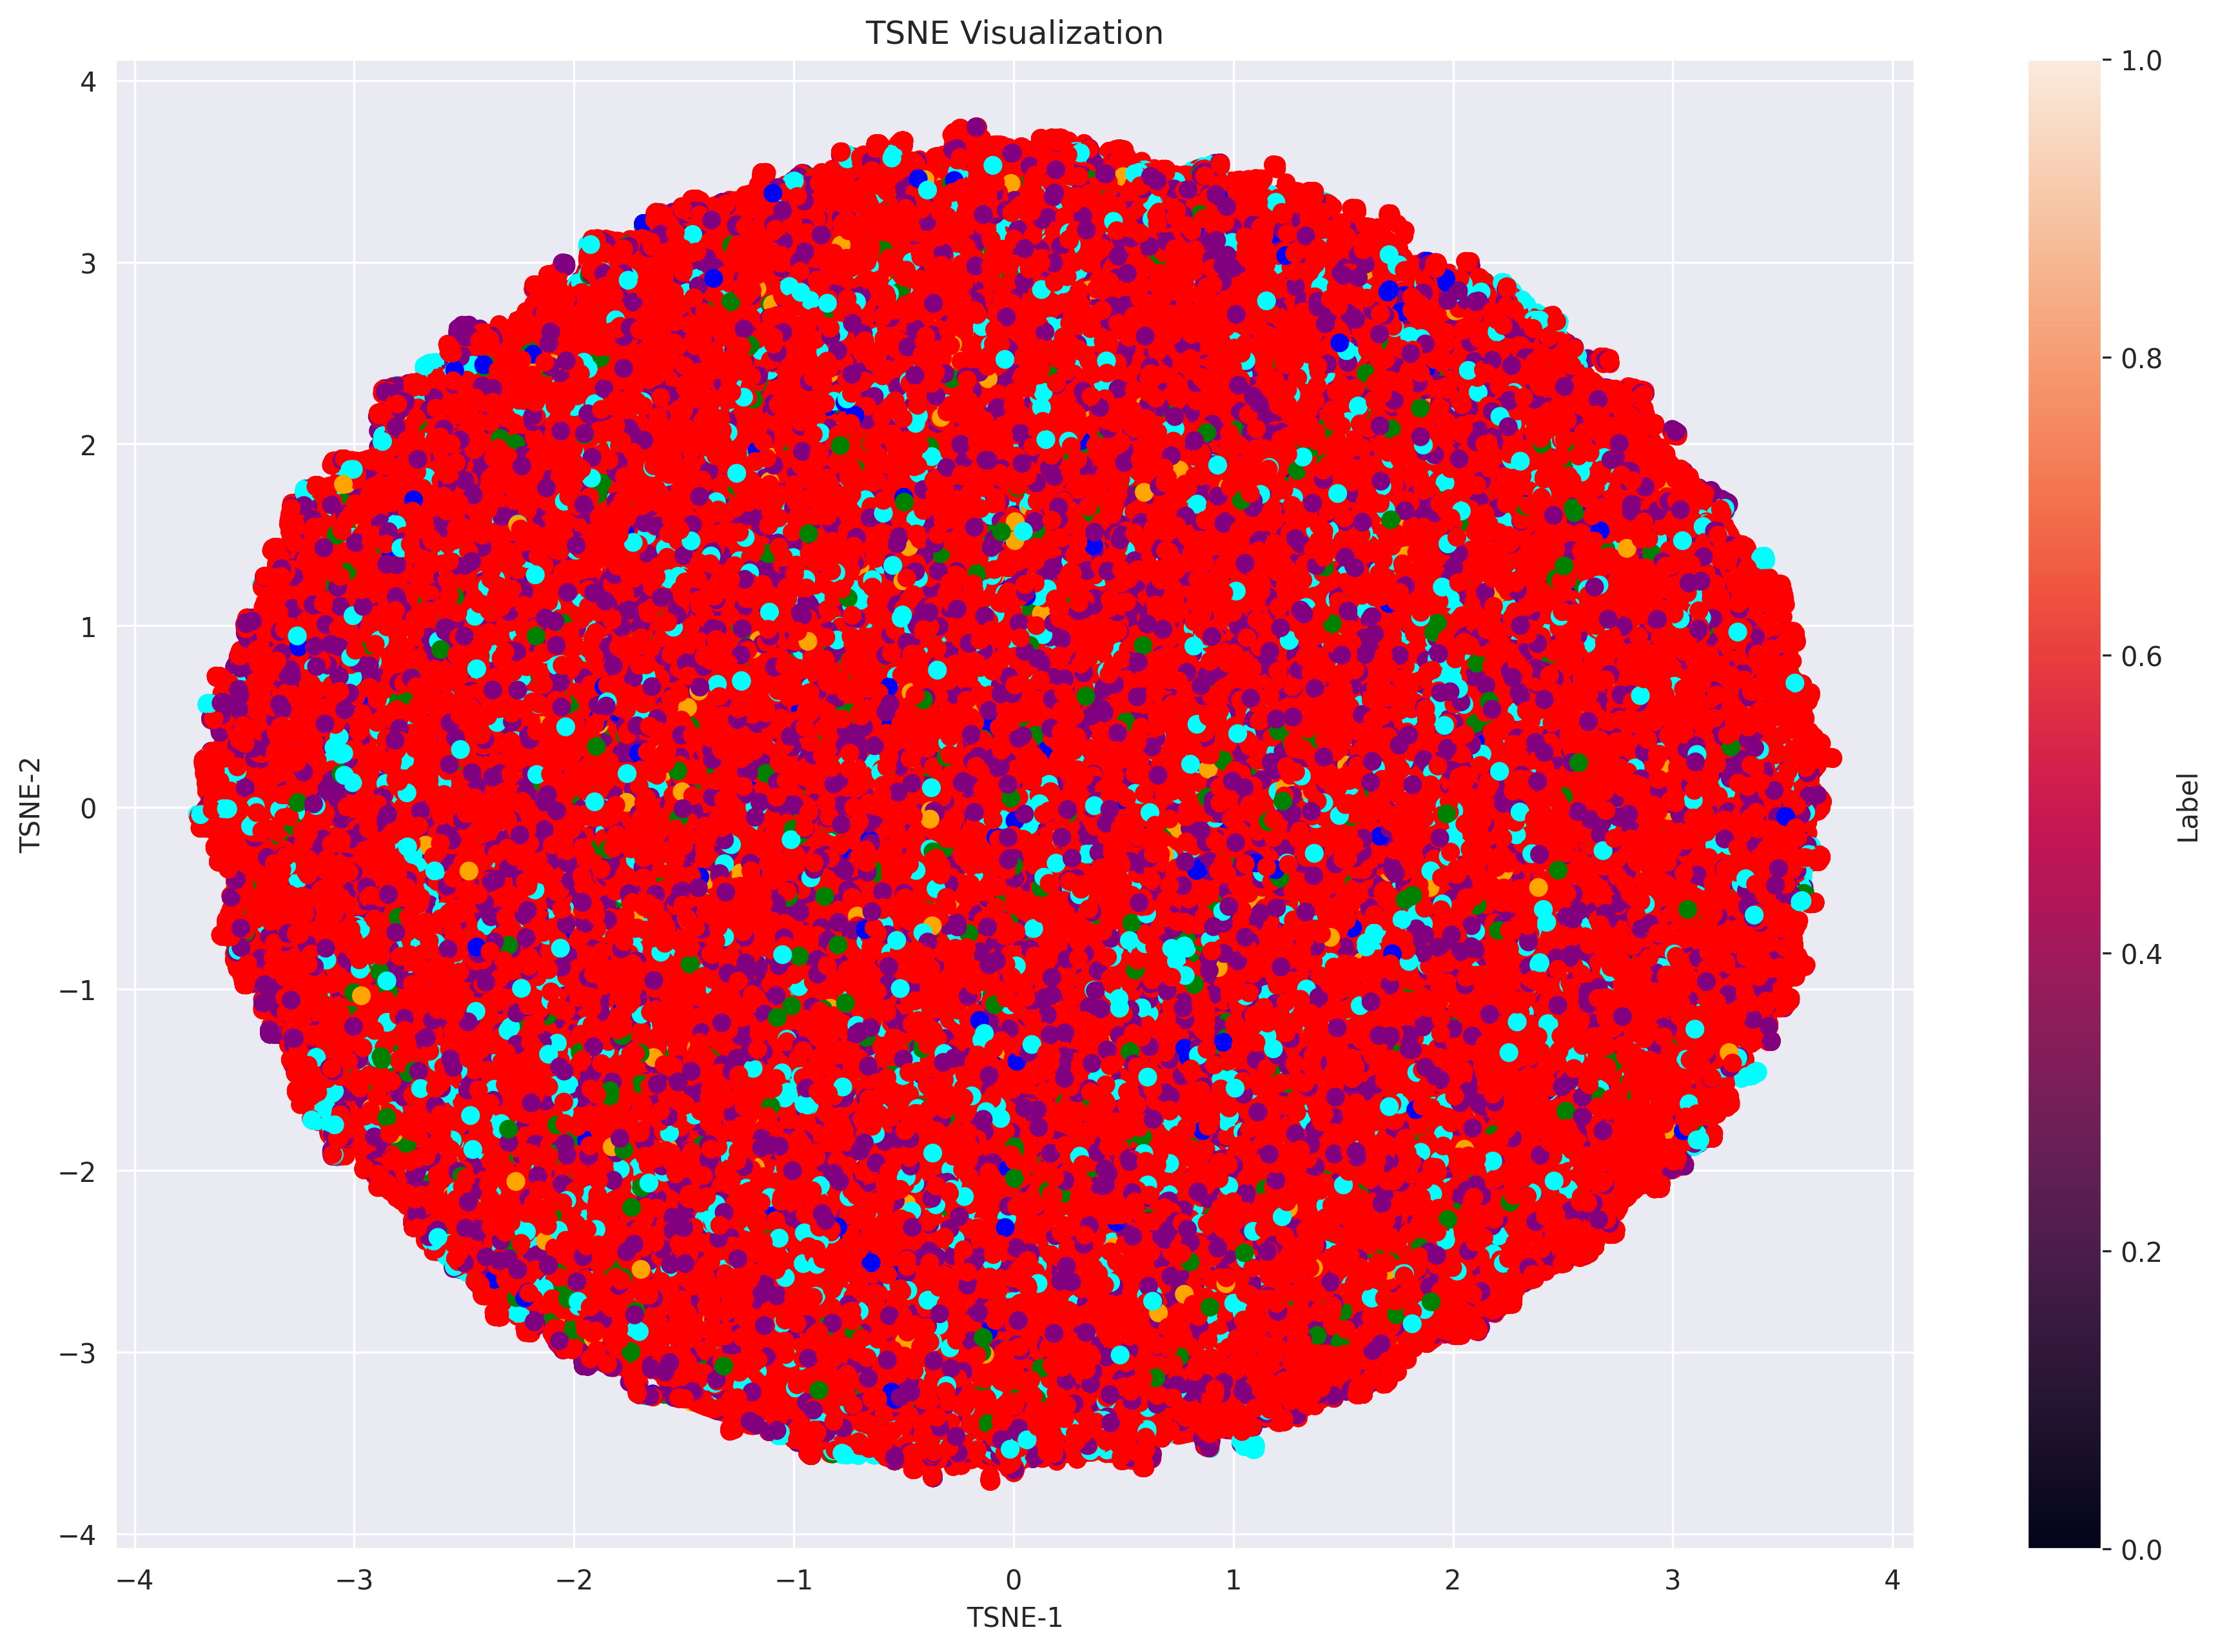

In [13]:
plt.figure(figsize=(15, 10) ,dpi=300)
plt.scatter(x=X_embedded_gpu[:, 0], y=X_embedded_gpu[:, 1] , 
c=df["label"].replace({
    "DDoS": "red",
    "Recon": "blue",
    "BenignTraffic": "green",
    "MITM": "orange",
    "DoS": "purple",
    "Mirai": "cyan"
})
            )
plt.colorbar(label='Label')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.title('TSNE Visualization')
plt.show()

In [ ]:
#https://youtu.be/_4OehmMYr44
from cuml.manifold import TSNE as TSNE_CPU
X_embedded_cpu = TSNE_CPU(n_components=2 , perplexity = 35  , verbose=1 ,method = "barnes_hut" ,
                          ).fit_transform(df.select(['flow_time', 'header_size', 'packet_duration', 'overall_rate', 'src_rate', 'fin_packets', 'urg_packets', 'rst_packets', 'max_value', 'value_covariance', 'fin_flags', 'syn_flags', 'rst_flags', 'psh_flags', 'ack_flags', 'protocol_http', 'protocol_https', 'protocol_tcp', 'protocol_udp', 'protocol_icmp']))

# Under and Over Smapling

In [43]:
X_np = df.select(selected_features).to_numpy()
y_np = y_numeric 

In [44]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import EditedNearestNeighbours, RandomUnderSampler
from cuml.ensemble import RandomForestClassifier

pipelines = {
    'enn': Pipeline([
        ('sampler', EditedNearestNeighbours()),
        # EditedNearestNeighbours under-sampling in CPU/NumPy :contentReference[oaicite:1]{index=1}
        ('clf',    RandomForestClassifier(output_type='numpy'))
        # cuML RF on GPU, returns NumPy array predictions :contentReference[oaicite:2]{index=2}
    ]),
    'rus': Pipeline([
        ('sampler', RandomUnderSampler()),
        # RandomUnderSampler in CPU/NumPy :contentReference[oaicite:3]{index=3}
        ('clf',    RandomForestClassifier(output_type='numpy'))
    ])
}


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'sampler__n_neighbors':   [3, 5, 7],       # only used by ENN :contentReference[oaicite:5]{index=5} 
    'clf__n_estimators':      [100, 200],
    'clf__max_depth':         [10, 20, None],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf':  [1, 2]
}

# Use CPU-side GridSearchCV; it will call our imblearn pipeline
grid_search = GridSearchCV(
    estimator=         pipelines['enn'],       # or 'rus'
    param_grid=        param_grid,
    scoring=           'accuracy',
    n_jobs=            -1,
    cv=                2                       # 3-fold CV :contentReference[oaicite:6]{index=6}
)
print(type(X_np) , type(y_np))
grid_search.fit(X_np, y_np.to_numpy())                    # X_np, y_np are NumPy arrays


<class 'numpy.ndarray'> <class 'cudf.core.series.Series'>


In [ ]:
from cuml.model_selection import train_test_split
from sklearn.metrics import classification_report

# 4.1 Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_np, y_np, test_size=0.25, random_state=42
)                                           # Standard NumPy split :contentReference[oaicite:9]{index=9}

# 4.2 Fit the best estimator
best_pipeline = grid_search.best_estimator_
best_pipeline.fit(X_train, y_train)         # Under-sampling on CPU, RF on GPU

# 4.3 Predict & evaluate
y_pred = best_pipeline.predict(X_test)      # returns NumPy array
print(classification_report(y_test, y_pred))
# classification_report takes NumPy arrays for y_true & y_pred :contentReference[oaicite:10]{index=10}


In [30]:
from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours(sampling_strategy='auto', n_neighbors=3, kind_sel='all', n_jobs=-1 )
X_res, y_res = enn.fit_resample(X_embedded_gpu,y_numeric.to_numpy())

DDoS             369652
DoS               10367
Mirai              7560
MITM               6313
BenignTraffic       685
Recon               279
Name: count, dtype: int64


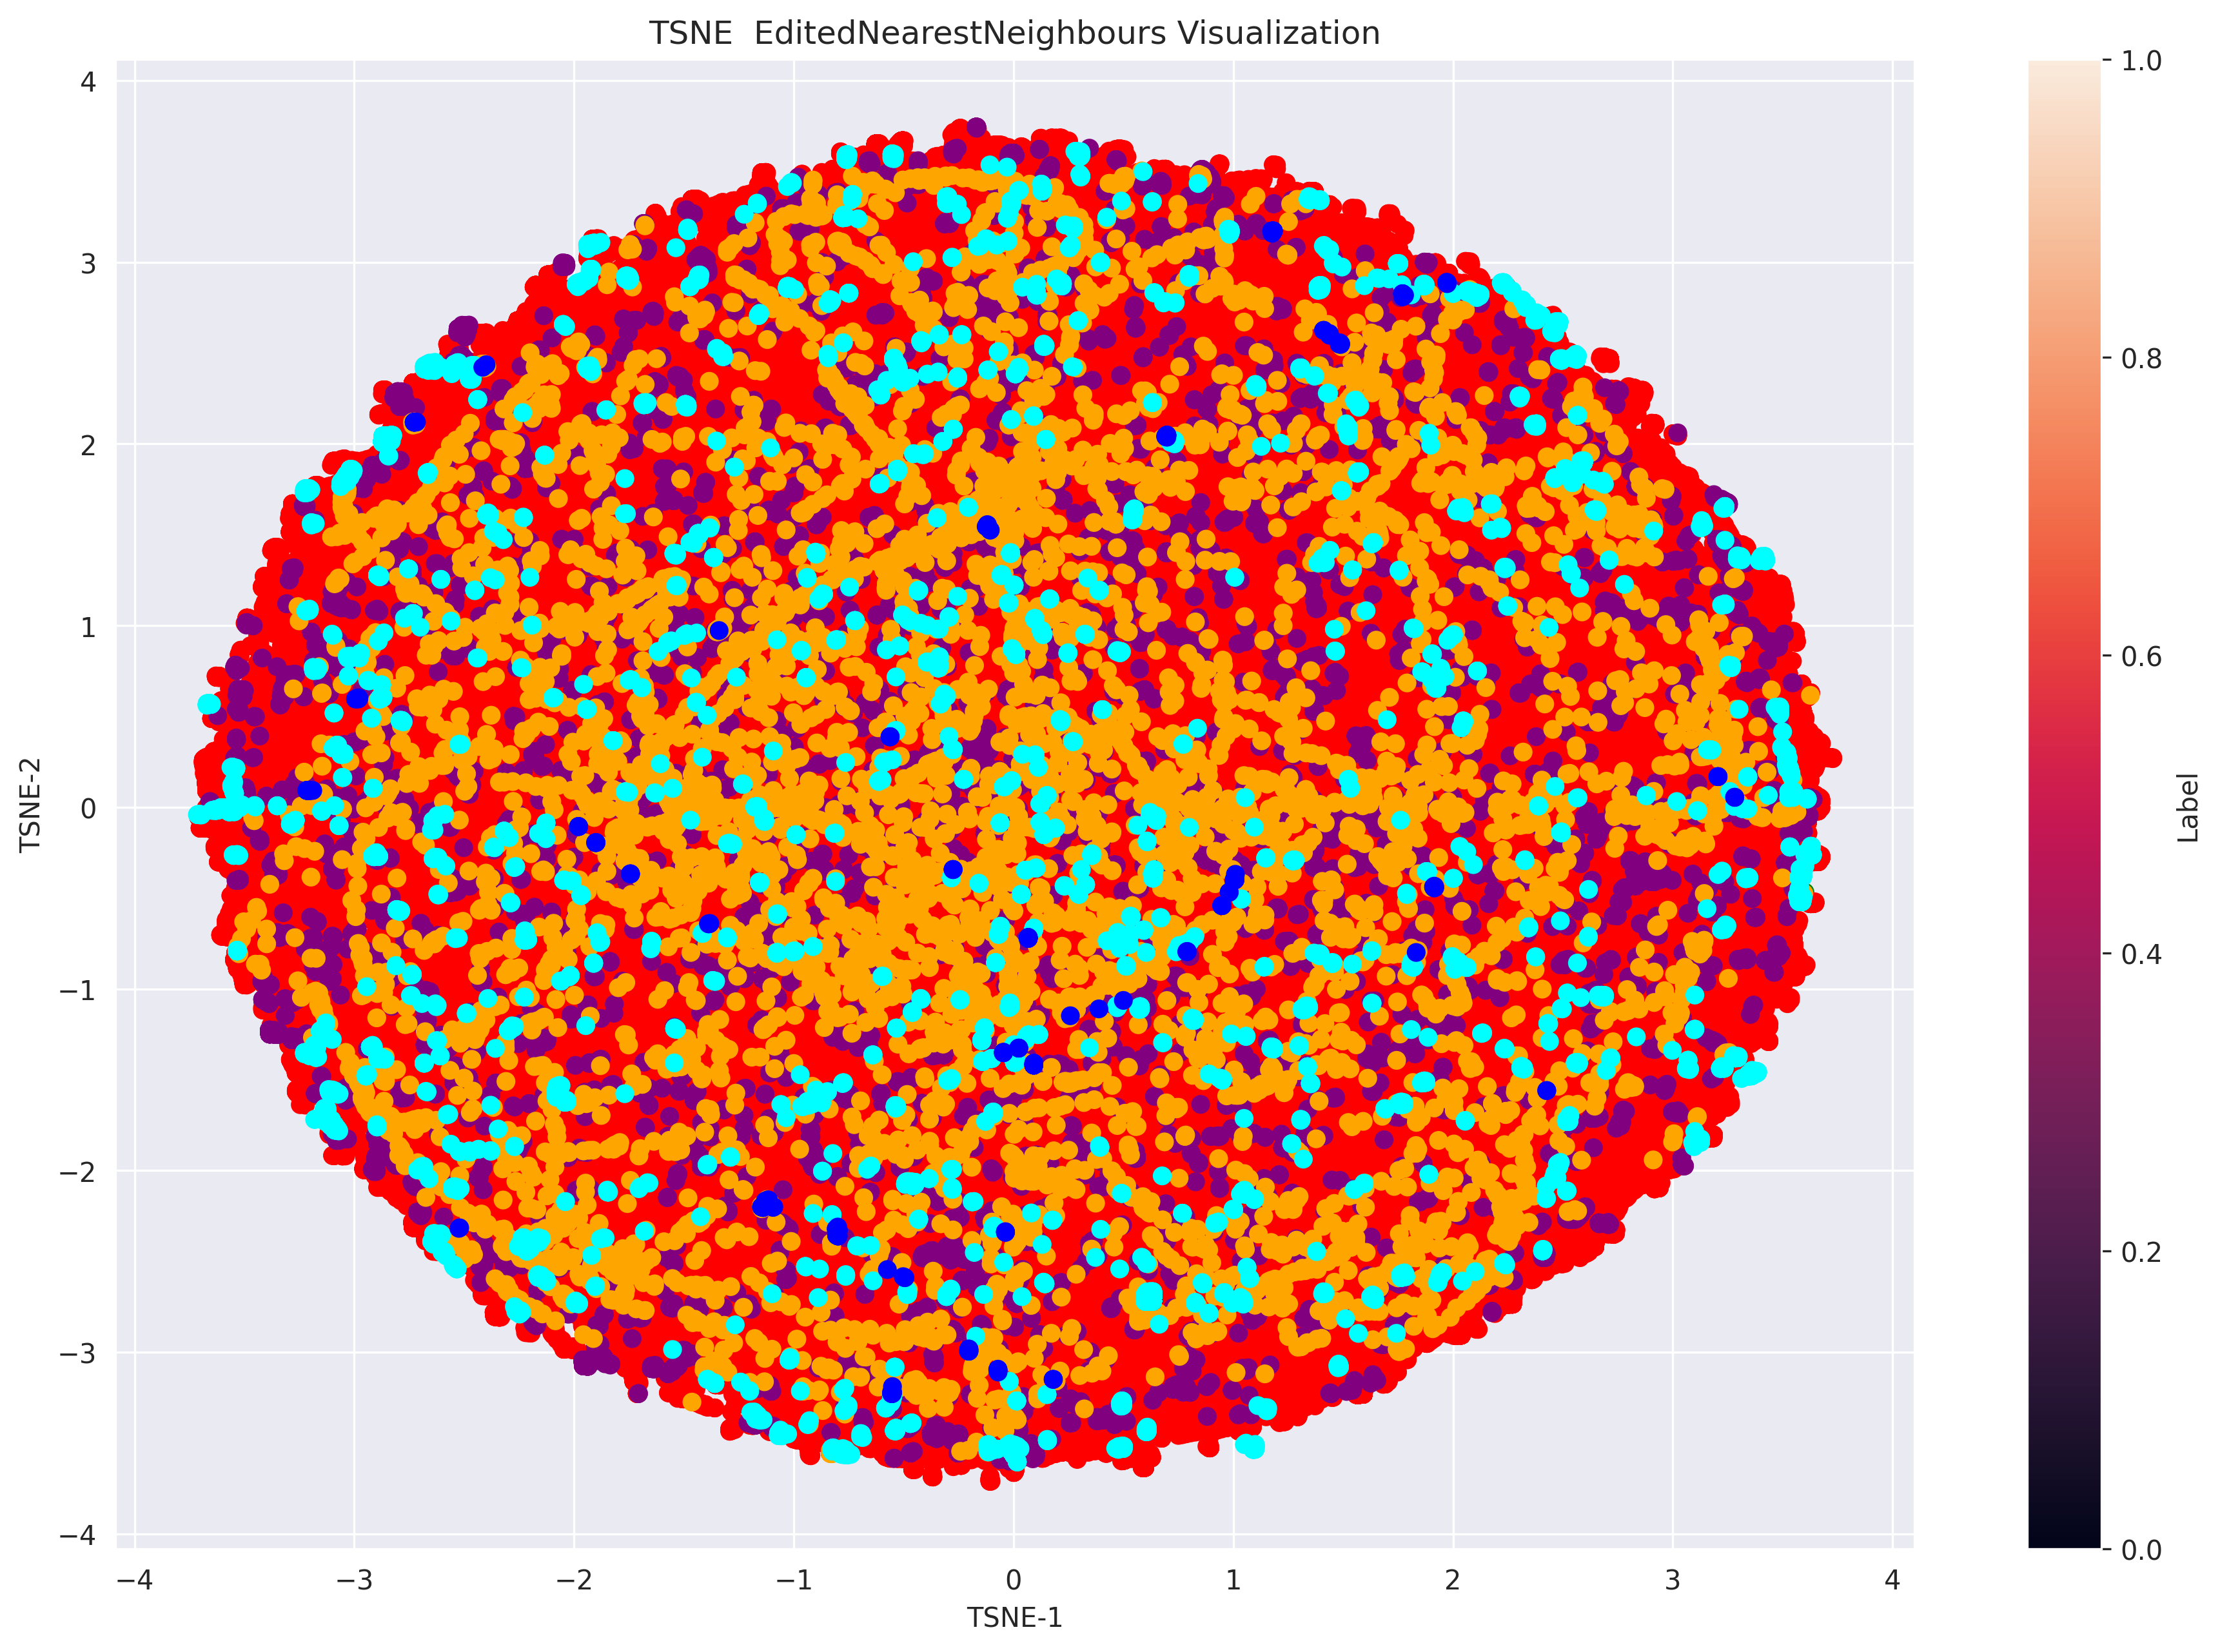

In [31]:
plt.figure(figsize=(15, 10) ,dpi=300)
plt.scatter(x=X_res[:, 0], y=X_res[:, 1] ,
            c=pd.Series(y_res).replace(map_).replace({
                "DDoS": "red",
                "Recon": "blue",
                "BenignTraffic": "green",
                "MITM": "orange",
                "DoS": "purple",
                "Mirai": "cyan"
            })
            )
print(pd.Series(y_res).replace(map_).value_counts())
plt.colorbar(label='Label')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.title('TSNE  EditedNearestNeighbours Visualization')
plt.show()

# Deprecated

In [131]:
# import rmm
# 
# # Reserve a 12 GiB pool on GPU 0
# rmm.reinitialize(
#     pool_allocator=True,
#     managed_memory=False,
#     initial_pool_size="12GB"
# )
# import cupy as cp
# 
# # free all unused device memory
# cp.get_default_memory_pool().free_all_blocks()
# 
# # free all unused pinned (host) memory
# cp.get_default_pinned_memory_pool().free_all_blocks()

import gc

# delete any large GPU-backed variables
del df_test, X_train, X_test, rf_model

# force Python GC
gc.collect()



NameError: name 'df_test' is not defined

# Conclusions

- abs on all numeric is bad for accuracy
- after some standardization we found that the data is standardized but there was 4 skewed features: ('header_size', 'overall_rate', 'src_rate', 'max_value') , which need to be standardized only not the whole dataset
- standard scaler gets higher results than robust scaler when being applied on ('header_size', 'overall_rate', 'src_rate', 'max_value')

- no outliers according to the context of the data
- we should investigate more in the imbalance problem